# BERT for Spam Classifier

In [ ]:
import tensorflow as tf

In [9]:
import tensorflow_hub as hub

In [10]:
import pandas as pd
df=pd.read_csv('E:\projects\spam classifier -BERT\spam.csv')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df=df.iloc[:,0:2]

In [12]:
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df=df.rename(columns={'v1':'category','v2':'Message'})

In [14]:
df.groupby('category').describe()

Message                                                            \
           count unique                                                top   
category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
category       
ham        30  
spam        4

In [15]:
df['category'].value_counts().unique()

array([4825,  747], dtype=int64)

In [16]:
df['category'].value_counts()

ham     4825
spam     747
Name: category, dtype: int64

In [17]:
747/4825

0.15481865284974095

#Working On Imbalance dataset to balanced Datasets

In [18]:
df_spam = df[df['category']=='spam']
df_spam.shape

(747, 2)

In [19]:
df_ham = df[df['category']=='ham']
df_ham.shape

(4825, 2)

In [20]:
ham_sample= df_ham.sample(df_spam.shape[0])
ham_sample.shape

(747, 2)

In [21]:
ham_sample

,category,Message
4578,ham,No plans yet. What are you doing ?
4083,ham,Quite ok but a bit ex... U better go eat smth ...
266,ham,"Not sure yet, still trying to get a hold of him"
4029,ham,"Cool, I'll text you in a few"
202,ham,Your account has been refilled successfully by...
...,...,...
257,ham,Where are you lover ? I need you ...
2855,ham,"Japanese Proverb: If one Can do it, U too Can ..."
1351,ham,Yo theres no class tmrw right?
4869,ham,Dip's cell dead. So i m coming with him. U bet...


In [22]:
goodset = pd.concat([ham_sample, df_spam])
goodset.shape

(1494, 2)

In [23]:
goodset['category'].value_counts()

ham     747
spam    747
Name: category, dtype: int64

In [24]:
goodset['spam']=goodset['category'].apply(lambda x: 1 if x=='spam' else 0)
goodset.sample(5)

,category,Message,spam
1289,ham,Hey...Great deal...Farm tour 9am to 5pm $95/pa...,0
2093,spam,Final Chance! Claim ur �150 worth of discount ...,1
1068,spam,Someone U know has asked our dating service 2 ...,1
4434,spam,Don't b floppy... b snappy & happy! Only gay c...,1
5228,spam,PRIVATE! Your 2003 Account Statement for <fone...,1


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(goodset['Message'],goodset['spam'], stratify=goodset['spam'])

In [26]:
X_train.head(4)

3562    Auction round 4. The highest bid is now �54. N...
582     We tried to contact you re your reply to our o...
4578                   No plans yet. What are you doing ?
1306    Enjoy the jamster videosound gold club with yo...
Name: Message, dtype: object

In [1]:
#goodset['Message'][4989]
#goodset['spam'][4989]

BERT preprocessor and encoder part from tensorflow hub

In [27]:
import tensorflow_text

In [28]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Example of how processor and encoder works

In [29]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


In [30]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [31]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.14219351,  0.49604717, ...,  0.42165396,
        -0.53221387,  0.8031216 ],
       [-0.86023223, -0.21242948,  0.49156877, ...,  0.39798012,
        -0.60506296,  0.84471667],
       [-0.712886  , -0.15463915,  0.38401613, ...,  0.35278702,
        -0.5099134 ,  0.73474085],
       [-0.82533467, -0.35550573, -0.59069717, ..., -0.01613736,
        -0.61417574,  0.8723029 ],
       [-0.7504134 , -0.2681264 , -0.26689714, ...,  0.02839344,
        -0.5938099 ,  0.7974988 ],
       [-0.78544414, -0.2994975 ,  0.41027203, ...,  0.5222531 ,
        -0.49573594,  0.8150757 ]], dtype=float32)>

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[1]],[e[3]])

array([[0.8773976]], dtype=float32)

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[4]])

array([[0.89336264]], dtype=float32)

Training BERT model and ANN

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'default': (None, 7 109482241   keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
______________________________________________________________________________________________

In [39]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 601s 16s/step - loss: 0.6320 - accuracy: 0.6241 - precision: 0.6280 - recall: 0.6089
Epoch 2/10
35/35 [==============================] - 516s 15s/step - loss: 0.5103 - accuracy: 0.8054 - precision: 0.7948 - recall: 0.8232
Epoch 3/10
35/35 [==============================] - 508s 14s/step - loss: 0.4371 - accuracy: 0.8652 - precision: 0.8520 - recall: 0.8839
Epoch 4/10
35/35 [==============================] - 529s 15s/step - loss: 0.3939 - accuracy: 0.8839 - precision: 0.8583 - recall: 0.9196
Epoch 5/10
35/35 [==============================] - 508s 15s/step - loss: 0.3690 - accuracy: 0.8795 - precision: 0.8670 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 527s 15s/step - loss: 0.3398 - accuracy: 0.9027 - precision: 0.8935 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 516s 15s/step - loss: 0.3238 - accuracy: 0.9080 - precision: 0.9073 - recall: 0.9089
Epoch 8/10
35/35 [=======================

In [40]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 167s 14s/step - loss: 0.2886 - accuracy: 0.9037 - precision: 0.8912 - recall: 0.9198


[0.2885790467262268, 0.903743326663971, 0.8911917209625244, 0.9197860956192017]

In [42]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [43]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
.cm

array([[166,  21],
       [ 15, 172]], dtype=int64)

Text(33.0, 0.5, 'Truth')

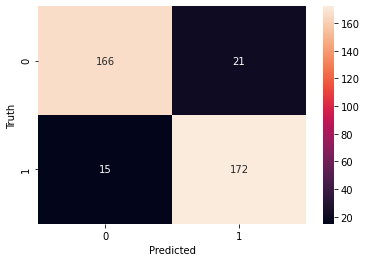

In [45]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.73441005],
       [0.7748325 ],
       [0.73967886],
       [0.18392304],
       [0.08608332]], dtype=float32)